In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
from collections import Counter
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
df_train = pd.read_csv('../data/en_emotion/train.txt', header =None, sep =';', names = ['Input','Sentiment'], encoding='utf-8')
df_test = pd.read_csv('../data/en_emotion//test.txt', header = None, sep =';', names = ['Input','Sentiment'],encoding='utf-8')
df_val=pd.read_csv('../data/en_emotion/val.txt',header=None,sep=';',names=['Input','Sentiment'],encoding='utf-8')

In [4]:
df_full = pd.concat([df_train,df_test,df_val], axis = 0)
df_full

,Input,Sentiment
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger
...,...,...
1995,im having ssa examination tomorrow in the morn...,sadness
1996,i constantly worry about their fight against n...,joy
1997,i feel its important to share this info for th...,joy
1998,i truly feel that if you are passionate enough...,joy


In [5]:
df_full['Sentiment'].value_counts()

joy         6761
sadness     5797
anger       2709
fear        2373
love        1641
surprise     719
Name: Sentiment, dtype: int64

In [6]:
df_full['Sentiment'] = df_full['Sentiment'].map({'surprise' : 1 , 'love' : 1 , 'joy' : 1 , 'sadness' : 0 , 'anger' : 0 , 'fear' : 0})

In [7]:
import text_hammer as th

In [8]:
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()

def text_preprocessing(df,col_name):
    column = col_name
    df[column] = df[column].progress_apply(lambda x:str(x).lower())
    df[column] = df[column].progress_apply(lambda x: th.cont_exp(x)) #you're -> you are; i'm -> i am
    df[column] = df[column].progress_apply(lambda x: th.remove_emails(x))
#     df[column] = df[column].progress_apply(lambda x: th.remove_html_tags(x))
#     df[column] = df[column].progress_apply(lambda x: ps.remove_stopwords(x))

    df[column] = df[column].progress_apply(lambda x: th.remove_special_chars(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_accented_chars(x))
#     df[column] = df[column].progress_apply(lambda x: th.make_base(x)) #ran -> run,
    return(df)

In [9]:
df_cleaned = text_preprocessing(df_full,'Input')

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

In [10]:
df_cleaned = df_cleaned.copy()

In [11]:
df_cleaned['num_words'] = df_cleaned.Input.apply(lambda x:len(x.split()))

<AxesSubplot:>

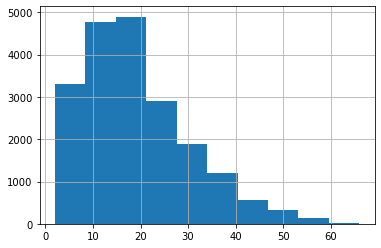

In [12]:
#단어 수가 66개가 넘는 데이터 없음
df_cleaned['num_words'].hist()

In [13]:
df_cleaned.num_words.max()

66

In [14]:
df_cleaned['Sentiment'] = df_cleaned['Sentiment'].astype('int') 

In [15]:
from sklearn.model_selection import train_test_split
data_train,data_test = train_test_split(df_cleaned, test_size = 0.3, random_state = 42, stratify = df_cleaned.Sentiment)

In [16]:
from transformers import AutoTokenizer,TFBertModel
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
bert = TFBertModel.from_pretrained('bert-base-cased')

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [17]:
tokenizer.save_pretrained('bert-tokenizer')
bert.save_pretrained('bert-model')

In [18]:
from transformers import BertTokenizer, TFBertModel, BertConfig,TFDistilBertModel,DistilBertTokenizer,DistilBertConfig
dbert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['activation_13', 'vocab_layer_norm', 'vocab_transform', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [19]:
x_train = tokenizer(
    text=data_train.Input.tolist(),
    add_special_tokens=True,
    max_length=70,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)


x_test = tokenizer(
    text=data_test.Input.tolist(),
    add_special_tokens=True,
    max_length=70,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

In [20]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import Accuracy

In [21]:
import tensorflow as tf
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]

In [22]:
max_len = 70
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense

input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
input_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")
# embeddings = dbert_model(input_ids,attention_mask = input_mask)[0]


embeddings = bert(input_ids,attention_mask = input_mask)[0] #(0 is the last hidden states,1 means pooler_output)
out = tf.keras.layers.GlobalMaxPool1D()(embeddings)
out = Dense(128, activation='relu')(out)
out = tf.keras.layers.Dropout(0.1)(out)
out = Dense(32,activation = 'relu')(out)

y = Dense(1,activation = 'sigmoid')(out)
    
model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)
model.layers[2].trainable = True
# for training bert our lr must be so small

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [23]:
optimizer = Adam(
    learning_rate=5e-05, # this learning rate is for bert model , taken from huggingface website 
    epsilon=1e-08,
    decay=0.01,
    clipnorm=1.0)

# Set loss and metrics
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
# Compile the model
model.compile(
    optimizer = optimizer,
    loss = loss, 
    metrics = ['accuracy'])

In [24]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 70)]         0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 70)]         0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 108310272   input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
global_max_pooling1d (GlobalMax (None, 768)          0           tf_bert_model[0][0]          

In [25]:
tf.config.experimental_run_functions_eagerly(True)
tf.config.run_functions_eagerly(True)

Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


In [26]:
train_history = model.fit(
    x ={'input_ids':x_train['input_ids'],'attention_mask':x_train['attention_mask']} ,
    y = data_train.Sentiment,
    validation_data = (
    {'input_ids':x_test['input_ids'],'attention_mask':x_test['attention_mask']}, data_test.Sentiment),
  epochs=1,
    batch_size=36
)

389/389 [==============================] - 144s 369ms/step - loss: 0.2616 - accuracy: 0.8806 - val_loss: 0.0560 - val_accuracy: 0.9757


In [79]:
model.save_weights('binary_sentiment_weights')

In [27]:
predicted_raw = model.predict({'input_ids':x_test['input_ids'],'attention_mask':x_test['attention_mask']})

In [28]:
predicted_raw

array([[9.9779934e-01],
       [9.6423155e-01],
       [5.9510866e-04],
       ...,
       [2.0405560e-04],
       [2.1132464e-04],
       [9.9909103e-01]], dtype=float32)

In [29]:
np.round(predicted_raw[0] , 0)

array([1.], dtype=float32)

In [30]:
y_predicted = np.around(predicted_raw,0)
y_predicted  = np.ravel(y_predicted)

In [31]:
from sklearn.metrics import classification_report

In [32]:
print(classification_report(data_test.Sentiment, y_predicted))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      3264
           1       0.98      0.96      0.97      2736

    accuracy                           0.98      6000
   macro avg       0.98      0.97      0.98      6000
weighted avg       0.98      0.98      0.98      6000



In [43]:
def emotion_predict(sentence):
    x_val = tokenizer(
        text=sentence,
        add_special_tokens=True,
        max_length=70,
        truncation=True,
        padding='max_length', 
        return_tensors='tf',
        return_token_type_ids = False,
        return_attention_mask = True,
        verbose = True)
    predict_value = model.predict({'input_ids':x_val['input_ids'],'attention_mask':x_val['attention_mask']})
    predict_answer = np.round(predict_value[0],0)
    
    if predict_answer == 0:
        print("{} : 0 ".format(sentence)) 
        #print("(부정 확률 : %.2f) 부정적인 감정입니다." % (1-predict_value))
        return 0
    elif predict_answer == 1:
        print("{} : 1".format(sentence))
        #print("(긍정 확률 : %.2f) 긍정적인 감정입니다." % predict_value)
        return 1

In [46]:
test_case = ["And I think you should be somethin'",
 'Maybe you should know that',
 "And I've been so caught up in my job didn't see what's going on",
 'And I never like to admit that I was wrong',
 'And now I know',
 "And baby I'll be movin' on",
 'For all the times that you rained on my parade',
 'And every time you told me my opinion was wrong',
 "I don't wanna hold back",
 'But when you told me that you hated my friends',
 "'Cause I didn't want anyone thinking I still care",
 "I fell in love now I feel nothin' at all",
 'And all the clubs you get in using my name',
 "I'm better sleeping on my own",
 'I never felt so low and I was vulnerable',
 "And I didn't wanna write a song",
 'The only problem was with you and not them',
 'You should go and love yourself',
 'For all the times that you made me feel small',
 "You think I'm crying on my own well I ain't",
 'You think you broke my heart oh girl for goodness sake',
 "I don't but you still hit my phone up",
 'And tried to make me forget where I came from',
 'Oh baby you should go and love yourself',
 "'Cause if you like the way you look that much",
 'Was I a fool to let you break down my walls',
 "My mama don't like you and she likes everyone",
 "And if you think that I'm still holdin' on to somethin'"]

In [47]:
for i in test_case:
    emotion_predict(i)

And I think you should be somethin' : 1
Maybe you should know that : 1
And I've been so caught up in my job didn't see what's going on : 0 
And I never like to admit that I was wrong : 0 
And now I know : 1
And baby I'll be movin' on : 1
For all the times that you rained on my parade : 0 
And every time you told me my opinion was wrong : 0 
I don't wanna hold back : 0 
But when you told me that you hated my friends : 0 
'Cause I didn't want anyone thinking I still care : 1
I fell in love now I feel nothin' at all : 1
And all the clubs you get in using my name : 0 
I'm better sleeping on my own : 1
I never felt so low and I was vulnerable : 0 
And I didn't wanna write a song : 0 
The only problem was with you and not them : 0 
You should go and love yourself : 1
For all the times that you made me feel small : 0 
You think I'm crying on my own well I ain't : 0 
You think you broke my heart oh girl for goodness sake : 0 
I don't but you still hit my phone up : 0 
And tried to make me forg